In [59]:
from qiskit import QuantumCircuit
from src.observable import create_parametrized_hermitian_matrix, hermitian_to_sparsepauliop, random_complex_vector, assign_parameters_to_matrix
from src.run_estimator import run_estimator
from scipy.optimize import minimize


# Create the parametrized matrix

In [60]:
n_qubits = 2

In [61]:
# Create a parametrized observable
N = 2**n_qubits
matrix = create_parametrized_hermitian_matrix(N)


# Create a circuit

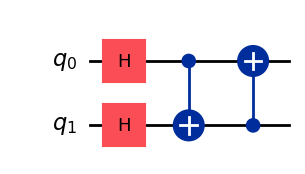

In [62]:
# Create a circuit of all H's followed by a CNOT circular chain
qc = QuantumCircuit(n_qubits)
qc.h(range(n_qubits))
for i in range(n_qubits):
    qc.cx(i, (i + 1) % n_qubits)
    
qc.draw('mpl', fold=-1)


# Create initial random parameters

In [63]:
n_params = N**2
range_real = (-1, 1)
range_imag = (-1, 1)

params = random_complex_vector(n_params, seed=0, range_real=range_real, range_imag=range_imag)


# Create observable

In [64]:
def create_operator_from_params(param_matrix, params, n_qubits):
    assigned_matrix = assign_parameters_to_matrix(param_matrix, params)
    sparse_pauli_op = hermitian_to_sparsepauliop(assigned_matrix, n_qubits)
    return sparse_pauli_op

# Run on Estimator

In [65]:
shots = 20_000

def run_circuit(qc, observable, shots):

    pubs = [(qc, observable)]
    result = run_estimator(pubs, shots)
    return result[0].data.evs.tolist()

# Prepare an optimizer

In [66]:


def evaluate_params(x):
    # Create the operator from the parameters
    observable = create_operator_from_params(matrix, x, n_qubits)
    # Run the circuit and get the expectation value
    ev = run_circuit(qc, observable, shots)
    return ev

In [70]:
from scipy.optimize import OptimizeResult
i_results = []
def callback(intermediate_result: OptimizeResult):
    i_results.append(intermediate_result.fun)

In [71]:
import numpy as np

# Trick for minimization: we need to convert the complex vector to real

def real_to_complex(z):      # real vector of length 2n -> complex of length n
    return z[:len(z)//2] + 1j * z[len(z)//2:]

def complex_to_real(z):      # complex vector of length n -> real of length 2n
    return np.concatenate((np.real(z), np.imag(z)))

In [72]:
optimizer = 'COBYQA'
bounds = [(-10, 10)] * n_params * 2  # 2n bounds for real and imaginary parts
result = minimize(lambda z: evaluate_params(real_to_complex(z)), complex_to_real(params),
                   method=optimizer, options={'maxiter': 10}, callback=callback)
print("Final result:")
print(result)
print(real_to_complex(result.x))


Final result:
 message: The maximum number of iterations has been exceeded
 success: False
  status: 6
     fun: -73.78238482895866
       x: [-1.857e+01 -1.755e+01 ... -4.784e-01  6.424e-01]
     nit: 10
   maxcv: 0.0
    nfev: 75
[-18.57142978-1.04574817j -17.55476362+0.66735347j
 -18.40958896+0.8042051j  -19.0870292 +0.42887202j
 -18.35979215+1.1157929j  -17.52651085+0.63455121j
 -19.14104977+0.31801539j -16.70707338+0.31801687j
 -17.94803199-0.69985966j -18.91344124+0.00582513j
 -19.06731692-0.75491461j -19.42276559+1.02833225j
 -18.55664297-0.21368928j -15.33839226+0.09293162j
 -18.69540135-0.47842844j -21.75487577+0.64240506j]


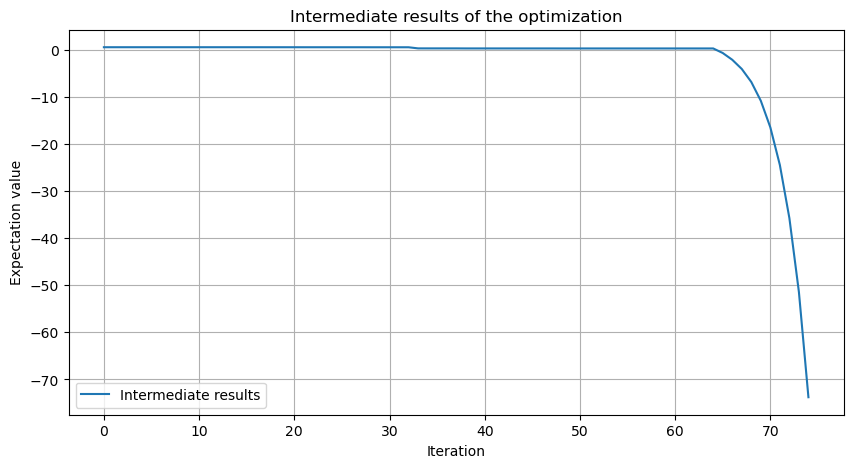

In [73]:
# Plot the intermediate results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(i_results, label='Intermediate results')
plt.xlabel('Iteration')
plt.ylabel('Expectation value')
plt.title('Intermediate results of the optimization')
plt.legend()
plt.grid()
plt.show()